In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A

import IPython.display as disp
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [2]:
%env WANDB_SILENT=true
set_seed(42); set_fast_norm()
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [3]:
DATA_PATH = Path('/data/')
CSV_PATH = DATA_PATH/'train.csv'
IMAGE_FOLDER = DATA_PATH/'train'

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

TIMM_MODEL = "beit_large_patch16_224"
NFOLDS = 5; BS = 32; SZ = 224

TRAIN_AUG = A.Compose([
    A.Resize(SZ, SZ),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(rotate_limit=360, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
    A.CoarseDropout(max_height=int(32*(SZ/512)), max_width=int(32*(SZ/512)), p=0.75), 
])

# CROP_PCT = 1.0
# SCALE_SZ = int(math.floor(SZ / CROP_PCT))
# from : 
# https://www.kaggle.com/code/titericz/imagenet-embeddings-rapids-svr-finetuned-models/notebook#But-what-happens-if-we-stack-some-architecture-features-side-by-side-before-fitting-the-SVR?
VALID_AUG = A.Compose([
    A.SmallestMaxSize(max_size=SZ + 16, p=1.0),
    A.CenterCrop(height=SZ, width=SZ, p=1.0),
])

In [4]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [5]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [6]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [7]:
# from timm.models.helpers import group_modules, group_parameters

# def timm_get_module_names(m):
#     modules_names = group_modules(m, m.group_matcher(coarse=True))
#     return L(modules_names.values())[:-1] #cut timm head

# def timm_get_param_names(m):
#     param_names = group_parameters(m, m.group_matcher(coarse=True))
#     return L(param_names.values())[:-1] #cut timm head

# def timm_body_params(timm_model, cut=-1):
#     param_names = timm_get_param_names(timm_model)
#     return L(param_names[:cut].concat(), param_names[cut:].concat())

# def timm_split(m, cut=-1):
#     "Splitter function for timm models"
#     timm_model, head = m[0].model, m[1]
#     body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
#     return body_groups + [params(head)]

In [8]:
def get_dls(fold:int):
    
    aug_tfm = AlbumentationsTransform(TRAIN_AUG, VALID_AUG)
    item_tfms = [aug_tfm, ToTensor]
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=BS)
    return dls

def build_experiment(fold:int = 0, pretrained:bool = True):
    dls = get_dls(fold)
    
    model = timm.create_model(TIMM_MODEL, pretrained=pretrained)
    model.reset_classifier(num_classes=dls.c)
    
    learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()
    learn.unfreeze()
    
    return dls, learn

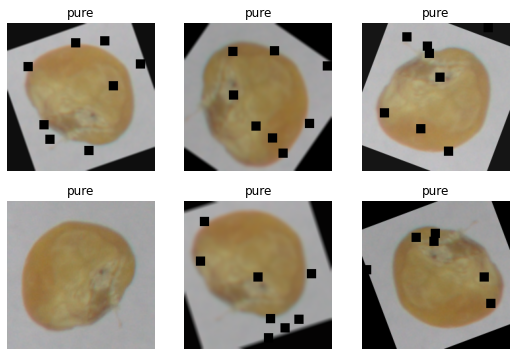

In [9]:
dls = get_dls(0)
dls.show_batch(max_n=6, unique=True)

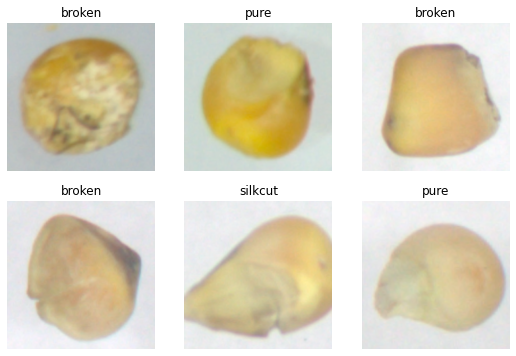

In [10]:
dls.valid.show_batch(max_n=6)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



SuggestedLRs(valley=0.0003981071640737355, slide=0.005248074419796467)
CPU: 2523/0/3948 MB | GPU: 3784/11714/4844 MB | Time 0:00:44.219 | (Consumed/Peaked/Used Total)


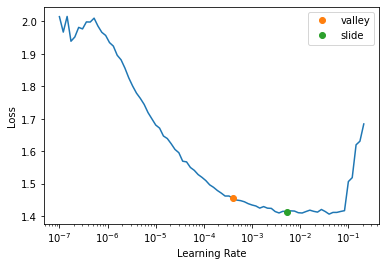

In [11]:
with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):      
    dls, learn = build_experiment(0)
    print(learn.lr_find(suggest_funcs=(valley, slide)))

In [12]:
VERSION  = "NB_EXP_024"
EXP_NAME = f"{VERSION}_beit_large_patch16" 

MODEL_FOLDER = Path(f'/runs/{VERSION}')
MODEL_FOLDER.mkdir(exist_ok=True)

n_epo = 16; base_lr = 3e-04;
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_mixup_ft"

print(f"EXP_NAME:{EXP_NAME}")
print(f"SUFFIX:{SUFFIX}; MODEL_FOLDER:{MODEL_FOLDER}")

EXP_NAME:NB_EXP_024_beit_large_patch16
SUFFIX:224_bs32_epo16_mixup_ft; MODEL_FOLDER:/runs/NB_EXP_024


In [13]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True): 
        print()
        print('*' * 100)
        print(f'Training fold {fold_idx}')
        print('*' * 100)
        
        print(f'fold:{fold_idx}; model:{TIMM_MODEL}; sz:{SZ}; bs:{BS}; epochs:{n_epo}; base_lr:{base_lr}')
        
        dls, learn = build_experiment(fold_idx)
        learn.fit_flat_cos(n_epo, base_lr, pct_start=0.0,
                           cbs=[MixUp(0.4), SaveModelCallback(monitor="accuracy", comp=np.greater)])

        learn = learn.load("model")
        learn = learn.to_fp32()

        dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
        learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************
fold:0; model:beit_large_patch16_224; sz:224; bs:32; epochs:16; base_lr:0.0003


epoch,train_loss,valid_loss,accuracy,time
0,1.145855,1.045985,0.537522,02:23
1,1.119779,0.993455,0.568237,02:23
2,1.075511,0.973170,0.585340,02:23
3,1.058708,0.980426,0.576963,02:24
4,1.048186,0.956044,0.579058,02:23
5,1.036356,0.936438,0.610820,02:24
6,1.005451,0.912387,0.615707,02:24
7,0.998624,0.921683,0.604538,02:24
8,0.985199,0.876949,0.623735,02:24
9,0.977416,0.875268,0.626178,02:24


Better model found at epoch 0 with accuracy value: 0.5375218391418457.
Better model found at epoch 1 with accuracy value: 0.5682373642921448.
Better model found at epoch 2 with accuracy value: 0.5853403210639954.
Better model found at epoch 5 with accuracy value: 0.6108202338218689.
Better model found at epoch 6 with accuracy value: 0.6157068014144897.
Better model found at epoch 8 with accuracy value: 0.623734712600708.
Better model found at epoch 9 with accuracy value: 0.6261780261993408.
Better model found at epoch 10 with accuracy value: 0.6282722353935242.
Better model found at epoch 12 with accuracy value: 0.6328097581863403.
Better model found at epoch 13 with accuracy value: 0.6342059373855591.
Better model found at epoch 14 with accuracy value: 0.6380453705787659.
Better model found at epoch 15 with accuracy value: 0.6418848037719727.
CPU: 1178/554/4502 MB | GPU: 2418/11770/7262 MB | Time 0:38:48.979 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backe

epoch,train_loss,valid_loss,accuracy,time
0,1.166481,1.075466,0.508551,02:24
1,1.116212,1.015574,0.552531,02:24
2,1.084002,1.000521,0.571728,02:24
3,1.049503,0.962624,0.587784,02:24
4,1.039760,0.928125,0.591972,02:24
5,1.027909,0.964950,0.594415,02:24
6,1.007029,0.914225,0.597208,02:24
7,0.988633,0.902694,0.614311,02:24
8,0.978953,0.868643,0.629668,02:24
9,0.979802,0.882560,0.629668,02:24


Better model found at epoch 0 with accuracy value: 0.5085514783859253.
Better model found at epoch 1 with accuracy value: 0.5525305271148682.
Better model found at epoch 2 with accuracy value: 0.5717277526855469.
Better model found at epoch 3 with accuracy value: 0.5877835750579834.
Better model found at epoch 4 with accuracy value: 0.5919720530509949.
Better model found at epoch 5 with accuracy value: 0.5944153666496277.
Better model found at epoch 6 with accuracy value: 0.5972076654434204.
Better model found at epoch 7 with accuracy value: 0.614310622215271.
Better model found at epoch 8 with accuracy value: 0.6296684145927429.
Better model found at epoch 11 with accuracy value: 0.6439790725708008.
CPU: 722/574/5224 MB | GPU: 430/13868/7692 MB | Time 0:38:53.869 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*********************************************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,1.174241,1.103740,0.503841,02:24
1,1.101203,1.008320,0.543645,02:24
2,1.070050,1.035562,0.542249,02:24
3,1.056141,0.977649,0.572626,02:24
4,1.040920,0.966306,0.577165,02:24
5,1.026915,0.939288,0.596369,02:24
6,1.001865,0.961491,0.582402,02:23
7,0.997949,0.931906,0.607542,02:23
8,0.969122,0.898542,0.614176,02:23
9,0.962664,0.896587,0.611383,02:23


Better model found at epoch 0 with accuracy value: 0.5038408041000366.
Better model found at epoch 1 with accuracy value: 0.5436452627182007.
Better model found at epoch 3 with accuracy value: 0.5726256966590881.
Better model found at epoch 4 with accuracy value: 0.5771648287773132.
Better model found at epoch 5 with accuracy value: 0.5963687300682068.
Better model found at epoch 7 with accuracy value: 0.6075419187545776.
Better model found at epoch 8 with accuracy value: 0.6141759753227234.
Better model found at epoch 10 with accuracy value: 0.6162709593772888.
Better model found at epoch 11 with accuracy value: 0.6173184514045715.
Better model found at epoch 12 with accuracy value: 0.6333798766136169.
CPU: -15/344/5209 MB | GPU: -222/13899/7470 MB | Time 0:38:40.277 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*****************************************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,1.173915,1.050319,0.522696,02:23
1,1.116424,1.038817,0.549930,02:23
2,1.105574,0.988771,0.563897,02:23
3,1.062348,0.994428,0.556564,02:23
4,1.060061,0.969895,0.580307,02:23
5,1.046940,0.919902,0.620461,02:23
6,1.022636,1.015078,0.535265,02:23
7,1.020277,0.939938,0.605098,02:23
8,0.980183,0.927670,0.604050,02:23
9,0.988529,0.925708,0.610684,02:23


Better model found at epoch 0 with accuracy value: 0.5226955413818359.
Better model found at epoch 1 with accuracy value: 0.5499301552772522.
Better model found at epoch 2 with accuracy value: 0.563896656036377.
Better model found at epoch 4 with accuracy value: 0.5803072452545166.
Better model found at epoch 5 with accuracy value: 0.6204608678817749.
Better model found at epoch 10 with accuracy value: 0.6414105892181396.
Better model found at epoch 13 with accuracy value: 0.6438547372817993.
Better model found at epoch 14 with accuracy value: 0.6539804339408875.
CPU: -112/104/5097 MB | GPU: 336/13790/7806 MB | Time 0:38:32.913 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 4
****************************************************************************************************
fold:4; model:

epoch,train_loss,valid_loss,accuracy,time
0,1.153741,1.116808,0.485684,02:23
1,1.109992,1.028287,0.545391,02:23
2,1.075609,0.995037,0.556564,02:23
3,1.079499,0.982175,0.562500,02:23
4,1.052637,0.980008,0.571229,02:23
5,1.034064,0.942896,0.594274,02:23
6,1.027005,0.953529,0.591480,02:23
7,1.008962,0.882095,0.629539,02:23
8,0.999003,0.904420,0.614525,02:23
9,0.995033,0.923526,0.598464,02:23


Better model found at epoch 0 with accuracy value: 0.4856843650341034.
Better model found at epoch 1 with accuracy value: 0.5453910827636719.
Better model found at epoch 2 with accuracy value: 0.5565642714500427.
Better model found at epoch 3 with accuracy value: 0.5625.
Better model found at epoch 4 with accuracy value: 0.5712290406227112.
Better model found at epoch 5 with accuracy value: 0.5942737460136414.
Better model found at epoch 7 with accuracy value: 0.6295391321182251.
Better model found at epoch 12 with accuracy value: 0.6361731886863708.
CPU: -37/112/5059 MB | GPU: -132/13794/7674 MB | Time 0:38:38.174 | (Consumed/Peaked/Used Total)


In [14]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        # hflip + vflip augs
#         tst_dl_hlip_vflip = dls.valid.new()
#         tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
#         dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip]
        
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

==> Load checkpoint from : 'NB_EXP_024_beit_large_patch16_224_bs32_epo16_mixup_ft_CV_00' (00)


* Accuracy : 0.641535758972168

==> Load checkpoint from : 'NB_EXP_024_beit_large_patch16_224_bs32_epo16_mixup_ft_CV_01' (01)


* Accuracy : 0.6436300277709961

==> Load checkpoint from : 'NB_EXP_024_beit_large_patch16_224_bs32_epo16_mixup_ft_CV_02' (02)


* Accuracy : 0.6326815485954285

==> Load checkpoint from : 'NB_EXP_024_beit_large_patch16_224_bs32_epo16_mixup_ft_CV_03' (03)


* Accuracy : 0.6543295979499817

==> Load checkpoint from : 'NB_EXP_024_beit_large_patch16_224_bs32_epo16_mixup_ft_CV_04' (04)


* Accuracy : 0.6337290406227112

CPU: 1425/178/6484 MB | GPU: -4546/5936/3128 MB | Time 0:03:54.328 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.64154, 0.64363, 0.63268, 0.65433, 0.63373]
Avg: 0.64118
Std: 0.00783
